In [1]:
import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.utils import to_categorical
from keras.utils import to_categorical
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

2024-04-19 07:15:19.996058: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-19 07:15:19.996202: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-19 07:15:20.185316: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data  = np.load("/kaggle/input/deap-fe-own-shuffled/Shuffled/PSD/DEAP_PSD_X.npy")
labels_edited  = np.load("/kaggle/input/deap-fe-own-shuffled/Shuffled/PSD/DEAP_PSD_arousal_y.npy")

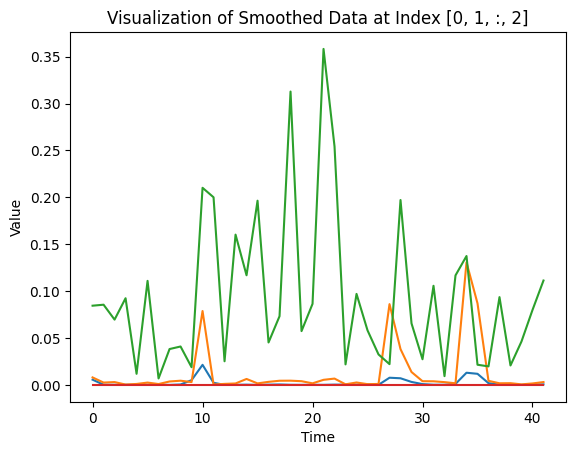

In [3]:
# Visualize the smoothed data
plt.plot(data[0, 2, :, :])
plt.title("Visualization of Smoothed Data at Index [0, 1, :, 2]")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

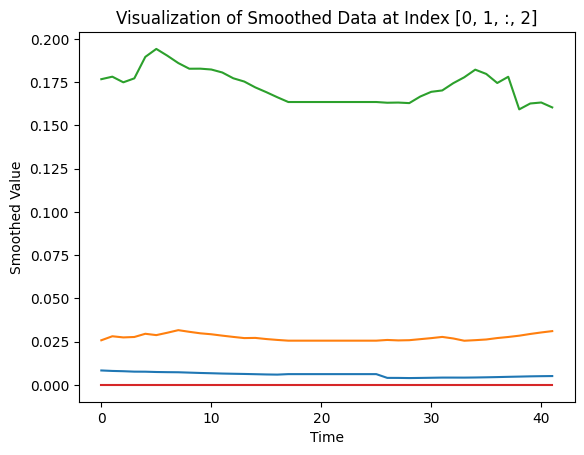

In [4]:
import pandas as pd

# Define the window size for the moving average filter
window_size = 50

# Apply the moving average filter
smoothed_data = np.zeros_like(data)
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        for k in range(data.shape[3]):
            series = pd.Series(data[i, j, :, k])
            smoothed_data[i, j, :, k] = series.rolling(window=window_size, center=True, min_periods=1).mean()

# Visualize the smoothed data
plt.plot(smoothed_data[1, 2, :, :])
plt.title("Visualization of Smoothed Data at Index [0, 1, :, 2]")
plt.xlabel("Time")
plt.ylabel("Smoothed Value")
plt.show()

In [5]:
data = smoothed_data

In [6]:
max = np.max(data)
min = np.min(data)

#Normalizing data
data = data/max
data = (data - np.mean(data))/np.std(data)


#Splitting Dataset into train, validation, test 
train_labels = labels_edited[0:1080]
test_labels = labels_edited[1080:1180]
final_labels = labels_edited[1180:1280]

train_data = data[0:1080]
test_data = data[1080:1180]
final_test = data[1180:1280]

# Calculate the unique labels and their counts
unique_labels, label_counts = np.unique(final_labels, return_counts=True)

# Print the unique labels and their counts
for label, count in zip(unique_labels, label_counts):
    print(f"Label: {label}, Count: {count}")

Label: 0, Count: 50
Label: 1, Count: 50


In [7]:
# Reshape train_data to be 2D (550, 62*265*5)
train_data_flattened = train_data.reshape(train_data.shape[0], -1)

# Reshape final_test to be 2D (75, 62*265*5)
final_test_flattened = final_test.reshape(final_test.shape[0], -1)

# One-hot encode labels
num_classes = 2  # Update with the actual number of classes
train_labels_encoded = to_categorical(train_labels, num_classes=num_classes)
final_labels_encoded = to_categorical(final_labels, num_classes=num_classes)

train_data_flattened.shape

(1080, 5376)

In [8]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC

# Define the hyperparameter grid
param_dist = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel type
    'gamma': ['scale', 'auto']  # Kernel coefficient
}

# Initialize the SVM model
svm_model = SVC()

# Perform Randomized Search Cross Validation
random_search = RandomizedSearchCV(estimator=svm_model, param_distributions=param_dist, n_iter=100, cv=5, random_state=42, n_jobs=-1)

# Fit the randomized search to the training data
random_search.fit(train_data_flattened, np.argmax(train_labels_encoded, axis=1))

# Get the best hyperparameters and the best score
best_params = random_search.best_params_
best_score = random_search.best_score_

# Print the best hyperparameters and the best score
print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)

# Use the best model for predictions
best_svm_model = random_search.best_estimator_
predictions = best_svm_model.predict(final_test_flattened)


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 32 is smaller than n_iter=100. Running 32 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best Hyperparameters: {'kernel': 'rbf', 'gamma': 'scale', 'C': 100}
Best Score: 0.576851851851852


In [9]:
# One-hot encode predictions
predictions_encoded = to_categorical(predictions, num_classes=num_classes)

In [10]:
# Calculate accuracy
accuracy = accuracy_score(np.argmax(final_labels_encoded, axis=1), np.argmax(predictions_encoded, axis=1))
# Print accuracy
print(f"Accuracy: {accuracy:.2%}")


Accuracy: 63.00%


Classification Report:
               precision    recall  f1-score   support

 Low Arousal       0.61      0.74      0.67        50
High Arousal       0.67      0.52      0.58        50

    accuracy                           0.63       100
   macro avg       0.64      0.63      0.63       100
weighted avg       0.64      0.63      0.63       100



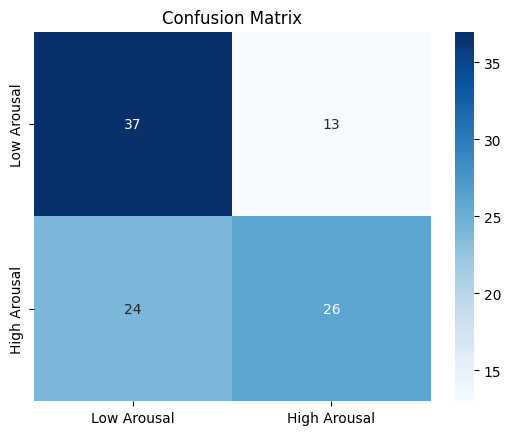

In [11]:
# Define custom class names
class_names = ['Low Arousal', 'High Arousal']

# Classification Report
class_report = classification_report(np.argmax(final_labels_encoded, axis=1), np.argmax(predictions_encoded, axis=1), target_names=class_names)
print("Classification Report:\n", class_report)

# Confusion Matrix
conf_matrix = confusion_matrix(np.argmax(final_labels_encoded, axis=1), np.argmax(predictions_encoded, axis=1))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.show()


In [12]:
from sklearn.metrics import accuracy_score, classification_report

# Define class names
class_names = ['Low Arousal', 'High Arousal']

# Calculate accuracy
accuracy = accuracy_score(np.argmax(final_labels_encoded, axis=1), np.argmax(predictions_encoded, axis=1))
print(f"Accuracy: {accuracy:.2%}")

# Classification Report
class_report = classification_report(
    np.argmax(final_labels_encoded, axis=1), 
    np.argmax(predictions_encoded, axis=1), 
    target_names=class_names,  # Use class_names here
    output_dict=True
)

# Convert to DataFrame for better manipulation
class_report_df = pd.DataFrame(class_report)
class_report_df = class_report_df.transpose()

# Convert values to percentages
class_report_df *= 100

# Append average metrics to the DataFrame
avg_metrics = pd.DataFrame(class_report_df.iloc[-1]).transpose()
class_report_df = class_report_df.drop(['accuracy', 'macro avg', 'weighted avg'])

class_report_df = pd.concat([class_report_df, avg_metrics], axis=0)

# Save the classification report as CSV
class_report_df.to_csv("classification_report.csv")

# Save the classification report as TXT
with open("classification_report.txt", "w") as text_file:
    text_file.write(classification_report(
        np.argmax(final_labels_encoded, axis=1), 
        np.argmax(predictions_encoded, axis=1), 
        target_names=class_names  # Use class_names here
    ))

# Display the classification report
print("Classification Report:\n", class_report_df)


Accuracy: 63.00%
Classification Report:
               precision  recall   f1-score  support
Low Arousal   60.655738    74.0  66.666667   5000.0
High Arousal  66.666667    52.0  58.426966   5000.0
weighted avg  63.661202    63.0  62.546816  10000.0


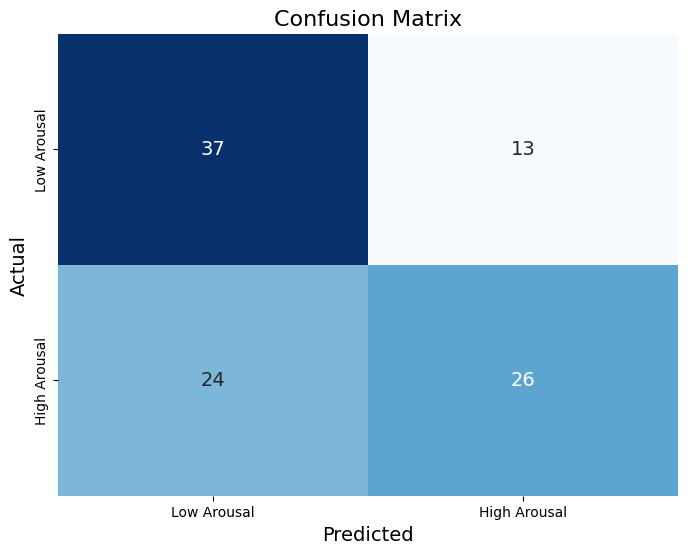

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Save Confusion Matrix as PDF
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, cbar=False, annot_kws={"size": 14})  # Use class_names here and adjust font size as needed
plt.title("Confusion Matrix", fontsize=16)  # Increase title font size
plt.xlabel('Predicted', fontsize=14)  # Increase x-axis label font size
plt.ylabel('Actual', fontsize=14)  # Increase y-axis label font size
plt.savefig("confusion_matrix.pdf", dpi=300, bbox_inches='tight')  # Save as PDF without extra margins
plt.show()
